In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# os.environ['JAX_PLATFORMS'] = 'cpu'

In [1]:
import pickle
from qiskit.quantum_info import SparsePauliOp
import json
from tangelo import SecondQuantizedMolecule
from tangelo.toolboxes.molecular_computation.integral_solver_pyscf import mol_to_pyscf, IntegralSolverPySCF
from tangelo.toolboxes.molecular_computation.frozen_orbitals import get_orbitals_excluding_homo_lumo
from time import time
from tangelo.algorithms import VQESolver, CCSDSolver, FCISolver
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.toolboxes.operators import count_qubits
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from scipy.stats import norm
from qiskit.circuit.library import RYGate, XGate
from qiskit.quantum_info import Operator
from qiskit_ibm_runtime import SamplerV2 as Sampler
import pyscf.mcscf
import pyscf
import pyscf.cc

In [2]:
your_api_key = "YOUR_API_KEY"
your_crn = "CRN"

from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(
#     channel="ibm_cloud",
#     token=your_api_key,
#     instance=your_crn,
#     set_as_default=True,
#     overwrite=True,
# )

In [3]:
# Check that the account has been saved properly
service = QiskitRuntimeService()
# service.saved_accounts()

In [4]:
backend = service.least_busy(operational=True, simulator=False)
backend

<IBMBackend('ibm_sherbrooke')>

In [9]:
# backend_options = {
#     "precision": "single",
#     "max_parallel_threads": 12,
#     "max_parallel_experiments": 0,
#     "max_parallel_shots": 0,
#     "fusion_enable": True,
#     "fusion_threshold": 14,
#     "fusion_max_qubit": 4,
#     "matrix_product_state_max_bond_dimension": 64,
#     "matrix_product_state_truncation_threshold": 1e-12,
#     "mps_sample_measure_algorithm": "mps_apply_measure",
#     "mps_parallel_threshold": 12,
#     "mps_omp_threads": 12,
#     "mps_lapack": False,
#     "seed_simulator": 42,
# }

# aer_sim = AerSimulator(method="matrix_product_state", **backend_options)
# aer_sim.set_max_qubits(200)

# pm = generate_preset_pass_manager(
#     backend=aer_sim, optimization_level=1, seed_transpiler=42
# )

In [6]:
with open("results/hams.pickle", "rb") as handle:
    hams_dict = pickle.load(handle)

with open('results/ccsd_res.npy', 'rb') as f:
    ccsd_res = np.load(f)

with open('results/fci_res.npy', 'rb') as f:
    fci_res = np.load(f)

In [7]:
def get_fractional_to_cartesian_matrix(a, b, c, alpha, beta, gamma,
                                       angle_in_degrees=True):
    if angle_in_degrees:
        # Convert angles to radians
        alpha = np.radians(alpha)
        beta = np.radians(beta)
        gamma = np.radians(gamma)
        
    lattice_a = np.array([a, 0, 0])
    lattice_b = np.array([b * np.cos(gamma), b * np.sin(gamma), 0])

    n2 = (np.cos(alpha) - np.cos(beta) * np.cos(gamma)) / np.sin(gamma)
    lattice_c = c * np.array([
        np.cos(beta),
        n2,
        np.sqrt(1 - np.cos(alpha)**2 - np.cos(beta)**2 - np.cos(gamma)**2 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)) / np.sin(gamma) 
    ])

    return np.array([lattice_a, lattice_b, lattice_c]).T

In [8]:
f = open('Li2FeSiO4.cif') # Li₂FeSiO₄
data = f.readlines()
data_lines = data[-16:]

def process(line):
    res = line.strip().split()
    atom = res[0][:-1]
    pos = [float(res[3]), float(res[4]), float(res[5])]

    if atom != 'Li':
        atom = atom[:-1]
    return (atom, pos)

res = list(map(process, data_lines))

symbols = [i[0] for i in res]
coords = [i[1] for i in res]

In [9]:
lattice_info = {}
for i in data[3:9]:
    res = i.strip().split()
    lattice_info[res[0].split('_')[-1]] = float(res[1])

lattice_info

{'a': 5.132302,
 'b': 11.037342,
 'c': 6.23237968,
 'alpha': 90.0,
 'beta': 91.30707992,
 'gamma': 90.0}

In [10]:
M = get_fractional_to_cartesian_matrix(*list(lattice_info.values()))
coords = (M @ (np.array(coords).T)).T

In [11]:
geometry = ""
for i, symbol in enumerate(symbols):
    geometry += f"{symbol} {coords[i][0]} {coords[i][1]} {coords[i][2]}\n"

In [12]:
class MyIntegralSolverPySCF(IntegralSolverPySCF):
    def compute_mean_field(self, sqmol):
        molecule = mol_to_pyscf(sqmol, sqmol.basis, sqmol.symmetry, sqmol.ecp)

        sqmol.mean_field = self.scf.RHF(molecule) if not sqmol.uhf else self.scf.UHF(molecule)
        sqmol.mean_field.verbose = 0
        sqmol.mean_field.conv_tol = 1e-5
        
        self.chkfile = 'mf_chkfile'
        sqmol.mean_field.chkfile = self.chkfile
        chkfile_found=True

        # Force broken symmetry for uhf calculation when spin is 0 as shown in
        # https://github.com/sunqm/pyscf/blob/master/examples/scf/32-break_spin_symm.py
        if sqmol.uhf and sqmol.spin == 0 and not chkfile_found:
            dm_alpha, dm_beta = sqmol.mean_field.get_init_guess()
            dm_beta[:1, :] = 0
            dm = (dm_alpha, dm_beta)
            sqmol.mean_field.kernel(dm)
        else:
            sqmol.mean_field.init_guess = "chkfile" if chkfile_found else "minao"
            sqmol.mean_field.kernel()

        sqmol.mean_field.analyze()
        if not sqmol.mean_field.converged:
            raise ValueError("Hartree-Fock calculation did not converge")

        if sqmol.symmetry:
            self.assign_mo_coeff_symmetries(sqmol)
        else:
            sqmol.mo_symm_ids = None
            sqmol.mo_symm_labels = None

        sqmol.mf_energy = sqmol.mean_field.e_tot
        sqmol.mo_energies = sqmol.mean_field.mo_energy
        sqmol.mo_occ = sqmol.mean_field.mo_occ

        sqmol.n_mos = molecule.nao_nr()
        sqmol.n_sos = 2*sqmol.n_mos

        self.mo_coeff = sqmol.mean_field.mo_coeff


class MySQMol(SecondQuantizedMolecule):    
    def __post_init__(self):
        self.solver = MyIntegralSolverPySCF()
        self.solver.set_physical_data(self)
        self.solver.compute_mean_field(self)
        self.freeze_mos(self.frozen_orbitals)

In [13]:
%%time
mol = MySQMol(geometry, q=0, spin=0, basis="sto3g", frozen_orbitals="frozen_core")

CPU times: user 21.8 s, sys: 2.45 s, total: 24.2 s
Wall time: 3.64 s


In [14]:
print(f"{mol.n_active_mos} active molecular orbitals")
print(f"{mol.n_active_electrons} active electrons")

92 active molecular orbitals
112 active electrons


In [93]:
level = 6

start = time()
frozen_orbitals = get_orbitals_excluding_homo_lumo(mol, homo_minus_n=level, lumo_plus_n=level)
frozen_mol = mol.freeze_mos(frozen_orbitals, inplace=False)

ccsd_solver = CCSDSolver(frozen_mol)
ccsd_energy = ccsd_solver.simulate()
print(f"{level} CCSD Energy:", ccsd_energy)

print(f"{frozen_mol.n_active_mos} active molecular orbitals")
print(f"{frozen_mol.n_active_electrons} active electrons")

print(level, "Duration:", time() - start)

6 CCSD Energy: -3688.184090389912
14 active molecular orbitals
14 active electrons
6 Duration: 5.632095575332642


In [94]:
t1 = ccsd_solver.solver.cc_fragment.t1
t2 = ccsd_solver.solver.cc_fragment.t2
num_orbitals = frozen_mol.n_active_mos
n_electrons = frozen_mol.n_active_electrons
num_elec_a = (n_electrons + frozen_mol.spin) // 2
num_elec_b = (n_electrons - frozen_mol.spin) // 2

print("Num qubits:", 2 * num_orbitals)

Num qubits: 28


In [95]:
cas = pyscf.mcscf.CASCI(frozen_mol.mean_field, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(frozen_mol.active_mos, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
# exact_energy = cas.run().e_tot # needs terabytes of memory
# exact_energy = fci_res[1][level]
exact_energy = ccsd_res[1][level]
exact_energy

-3688.23705603126

In [98]:
import ffsim
from qiskit import QuantumCircuit, QuantumRegister

n_reps = 2
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    # t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    # interaction_pairs=None
)

nelec = frozen_mol.n_active_ab_electrons

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

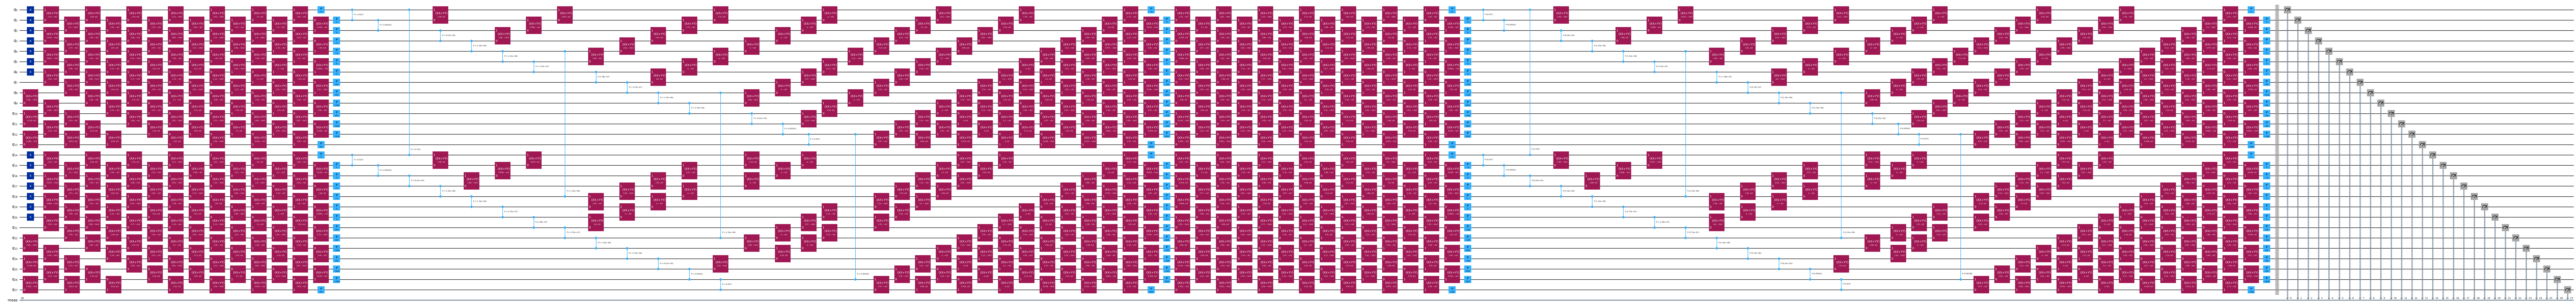

In [99]:
circuit.decompose().decompose().draw('mpl', fold=-1)

In [100]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(circuit)
sum(isa_circuit.count_ops().values())

11232

In [53]:
# isa_circuit.draw('mpl', fold=-1)

In [101]:
from qiskit_addon_sqd.counts import generate_bit_array_uniform

n_shots = 10000

sampler = Sampler(mode=backend)
sampler.options.default_shots = n_shots

job = sampler.run([isa_circuit])

In [103]:
job.status()

'DONE'

In [104]:
primitive_result = job.result()
pub_result = primitive_result[0]
bit_array = pub_result.data.meas

In [ ]:
from functools import partial
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_dice_solver import solve_sci_batch

# SQD options
energy_tol = 1e-8
occupancies_tol = 1e-8
max_iterations = 5

# Eigenstate solver options
num_batches = 4
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-8
max_cycle = 200

# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
# sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


rng = np.random.default_rng(24)
result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=solve_sci_batch,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

Exact energy: -3688.23705603126 Ha
SQD energy: -3688.1431752639014 Ha
Absolute error: 0.09388076735876894 Ha


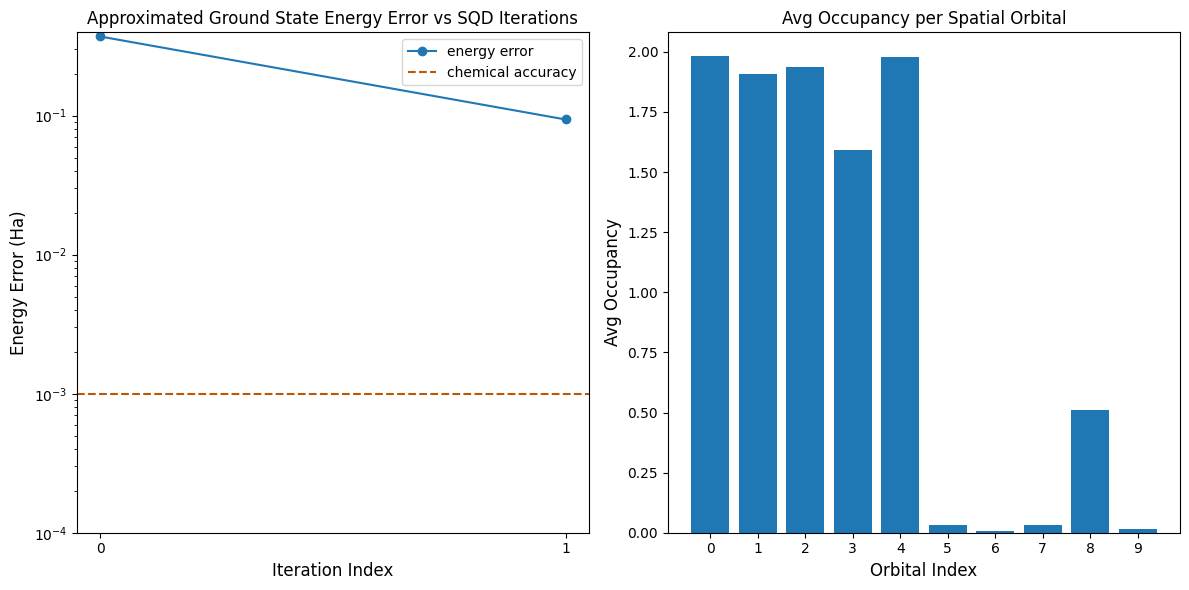

In [106]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:} Ha")
print(f"SQD energy: {min_e[-1]} Ha")
print(f"Absolute error: {e_diff[-1]} Ha")
plt.tight_layout()
plt.show()

In [107]:
isa_circuit.depth()

756

In [108]:
sqd_energies_hardware = [
   -3687.934656831271,
   -3687.9366424495233,
   -3688.047925427873,
   -3688.0559795388735
   -3688.072497093222,
   -3688.1431752639014
]
times = [4, 4, 4, 5, 5, 5]
depth_hardware = [
    161,
    289,
    321,
    467,
    471,
    756
]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

# Example data
n_config = 10             # number of configurations
n_orbitals = 16           # number of orbitals per config

# Generate random configurations (0 or 1)
np.random.seed(0)
configs = np.random.randint(0, 2, size=(n_config, n_orbitals))

# Example quasi-probabilities
probs = np.random.rand(n_config)
probs /= probs.sum()  # normalize to sum to 1

# Sort by probability
sorted_indices = np.argsort(probs)[::-1]
configs = configs[sorted_indices]
probs = probs[sorted_indices]

# Plotting
fig, ax = plt.subplots(figsize=(10, 4))

# Axes for config dots
ax.set_xlim(-1, n_orbitals + 1)
ax.set_ylim(-1, n_config)
ax.set_xticks([])
ax.set_yticks(np.arange(n_config))
ax.set_yticklabels(['']*n_config)  # or use [f"{i}" for i in range(n_config)]
ax.set_xlabel('')
ax.set_ylabel("Electron Config.")

# Draw filled/unfilled circles
for row in range(n_config):
    for col in range(n_orbitals):
        val = configs[row, col]
        color = 'black' if val == 1 else 'white'
        edge = 'black'
        circle = Circle((col, row), 0.4, facecolor=color, edgecolor=edge, linewidth=1)
        ax.add_patch(circle)

# Create twin axis for probabilities
ax_prob = ax.inset_axes([1.02, 0, 0.25, 1.0], sharey=ax)
ax_prob.barh(np.arange(n_config), probs, color='skyblue')
ax_prob.set_xlabel("Quasi-probability")
ax_prob.set_yticks([])

# Tidy up
ax.invert_yaxis()
plt.tight_layout()
plt.show()


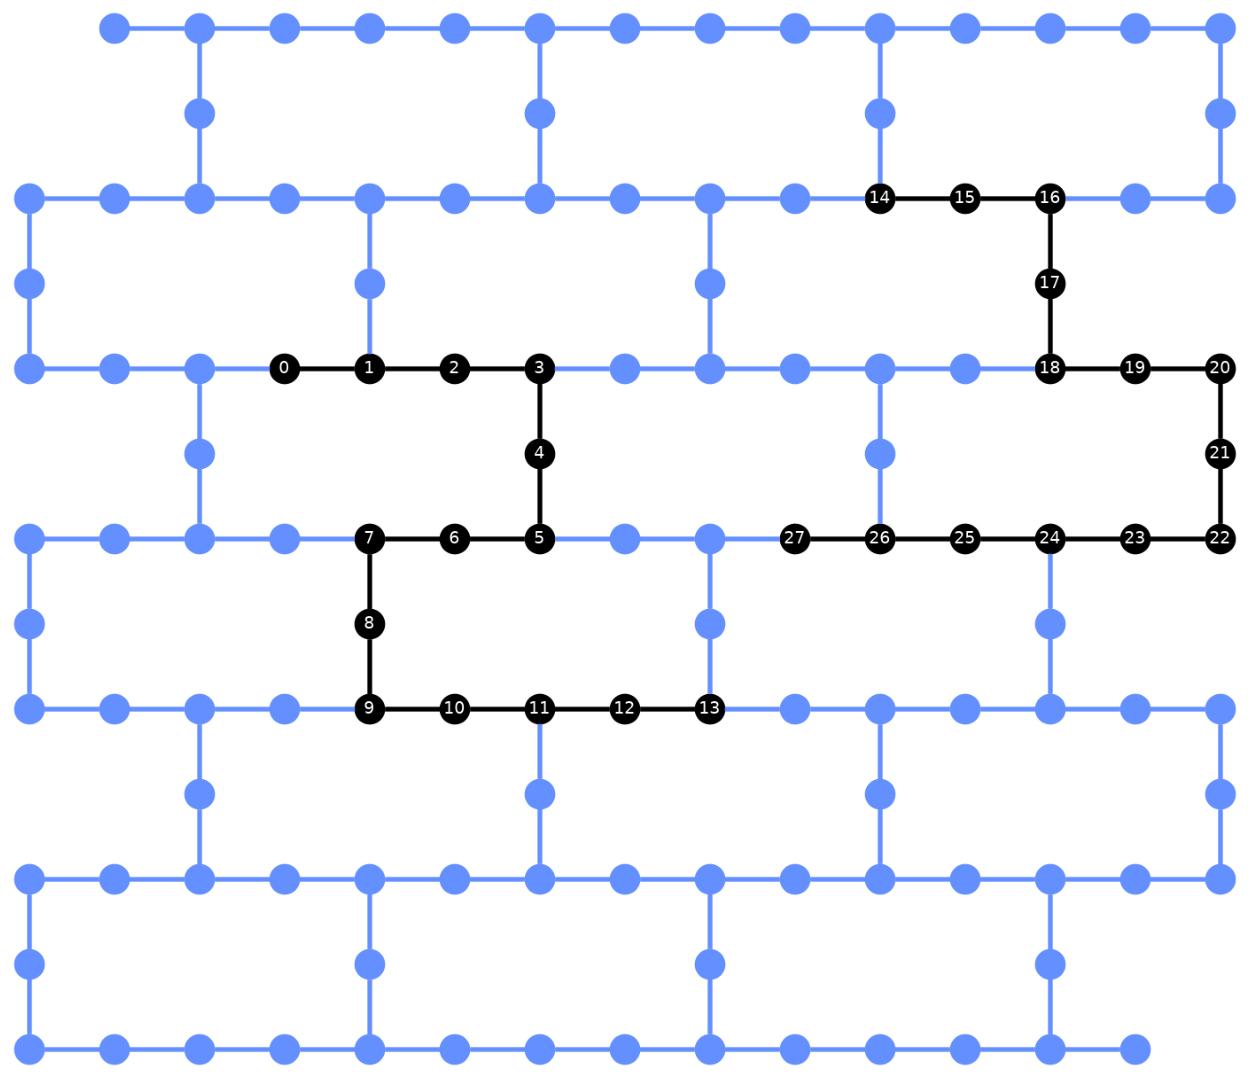

In [116]:
from qiskit.visualization import plot_circuit_layout
# fig = plot_circuit_layout(isa_circuit, backend)
# fig.savefig('results/circuit_to_chip_map_28_qubit.png', dpi=300)
plot_circuit_layout(isa_circuit, backend)

In [ ]:
# # Load the contextuals hamiltonians and hartree fock statess
# with open("results/hams.pickle", "rb") as handle:
#     hams = pickle.load(handle)

In [ ]:
# hamiltonians = []
# for level, ham_dict in hams.items():
#     coeffs = ham_dict['coeffs']
#     terms = ham_dict['terms']
#     hamiltonians.append(SparsePauliOp(terms, coeffs))

In [ ]:
# for ham in hamiltonians:
#     print(ham.num_qubits)